In [2]:
#################################################################
# Load data
#################################################################

import os
os.environ["NFL_HOME"] = "/home/sam/repos/hobby-repos/nfl/"

from common.data_loader import RawDataLoader

# Get raw data
loader = RawDataLoader()
games_df, plays_df, players_df, location_data_df = loader.get_data(weeks=[week for week in range (1,10)])

print(location_data_df.head(10))

       gameId  playId    nflId     displayName  frameId    frameType  \
0  2022091200      64  35459.0  Kareem Jackson        1  BEFORE_SNAP   
1  2022091200      64  35459.0  Kareem Jackson        2  BEFORE_SNAP   
2  2022091200      64  35459.0  Kareem Jackson        3  BEFORE_SNAP   
3  2022091200      64  35459.0  Kareem Jackson        4  BEFORE_SNAP   
4  2022091200      64  35459.0  Kareem Jackson        5  BEFORE_SNAP   
5  2022091200      64  35459.0  Kareem Jackson        6  BEFORE_SNAP   
6  2022091200      64  35459.0  Kareem Jackson        7  BEFORE_SNAP   
7  2022091200      64  35459.0  Kareem Jackson        8  BEFORE_SNAP   
8  2022091200      64  35459.0  Kareem Jackson        9  BEFORE_SNAP   
9  2022091200      64  35459.0  Kareem Jackson       10  BEFORE_SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-09-13 00:16:03.5          22.0  DEN         right  51.06  28.55  0.72   
1  2022-09-13 00:16:03.6          22.0  DEN  

In [3]:
#################################################################
# Filter down plays df to situations we are interested in
#################################################################
filtered_plays_df = plays_df.copy()

# Find the starting plays
print("Filtering data...")
original_play_length = len(filtered_plays_df)
print(f'Total plays: {original_play_length}')

# Filter out penalties
filtered_plays_df = filtered_plays_df[filtered_plays_df['playNullifiedByPenalty'] == 'N']
# Filter out rows with 'PENALTY' in the 'playDescription' column
filtered_plays_df = filtered_plays_df[~filtered_plays_df['playDescription'].str.contains("PENALTY", na=False)]
print(f'Total plays after filtering out penalties: {len(filtered_plays_df)}')

# Filter down to valid Man or Zone defensive play calls
filtered_plays_df = filtered_plays_df[filtered_plays_df['pff_manZone'].isin(['Man', 'Zone'])]
print(f'Total plays after filtering to valid Man or Zone classifications: {len(filtered_plays_df)}')

# Filter for only rows that indicate a pass play
filtered_plays_df = filtered_plays_df[filtered_plays_df['passResult'].notna()]
print(f'Total plays after filtering to only pass plays: {len(filtered_plays_df)}')

# Filter for only plays where the win probablity isn't lopsided (between 0.2 and 0.8)
filtered_plays_df = filtered_plays_df[(filtered_plays_df['preSnapHomeTeamWinProbability'] > 0.1) & (filtered_plays_df['preSnapHomeTeamWinProbability'] < 0.9)]
print(f'Total plays after filtering out garbage time: {len(filtered_plays_df)}')

# Filter for only third down or fourth down plays
# filtered_plays_df = filtered_plays_df[filtered_plays_df['down'].isin([3, 4])]
# print(f'Total plays after filtering for 3rd or 4th down: {len(filtered_plays_df)}')

# Filter for plays that are in our gameIds (in location data df)
filtered_plays_df = filtered_plays_df[filtered_plays_df['gameId'].isin(location_data_df['gameId'].unique())]
print(f'Total plays after making sure they are in our location data: {len(filtered_plays_df)}')

print(filtered_plays_df.columns)

Filtering data...
Total plays: 16124
Total plays after filtering out penalties: 15908
Total plays after filtering to valid Man or Zone classifications: 14910
Total plays after filtering to only pass plays: 9103
Total plays after filtering out garbage time: 7079
Total plays after making sure they are in our location data: 7079
Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure'

In [4]:
#################################################################
# Cut down df to only cols we care about
#################################################################
# Cut down to columns we care about
keep_cols_from_plays = ['gameId', 'playId', 'possessionTeam', 'defensiveTeam', 'pff_manZone']
filtered_plays_df = filtered_plays_df.loc[:, keep_cols_from_plays].drop_duplicates()

# Make sure we don't have any NAs in this cut down col df
filtered_plays_df.dropna()
print(f'Total plays after cutting down to our cols and dropping NAs: {len(filtered_plays_df)}')

# Print total plays
print(filtered_plays_df.head())

Total plays after cutting down to our cols and dropping NAs: 7079
        gameId  playId possessionTeam defensiveTeam pff_manZone
1   2022091809    3698            CIN           DAL        Zone
3   2022110610     348             KC           TEN        Zone
9   2022100204    1422            DAL           WAS        Zone
10  2022100912     445            DAL            LA        Zone
13  2022110603    2325             GB           DET        Zone


In [5]:
#################################################################
# Create merged df that has gameId, playId, frameID all before SNAP, with x, y, and offense/defense
#################################################################
import pandas as pd
import numpy as np

# Create a copy of the location tracking data, cut it down to columns we care about
loc_trimmed_df = location_data_df.copy()
keep_cols  = [
    'gameId',
    'playId',
    'nflId',
    'frameId',
    'frameType',
    'club',
    'x',
    'y',
    's',
    'a'
]
loc_trimmed_df = location_data_df.loc[:, keep_cols]

# Cut down location tracking data copy to only before the snap and where the team isn't valid
loc_trimmed_df = loc_trimmed_df[(loc_trimmed_df["frameType"] == "BEFORE_SNAP") & (loc_trimmed_df["club"] != "football")]

print(loc_trimmed_df.head())

       gameId  playId    nflId  frameId    frameType club      x      y     s  \
0  2022091200      64  35459.0        1  BEFORE_SNAP  DEN  51.06  28.55  0.72   
1  2022091200      64  35459.0        2  BEFORE_SNAP  DEN  51.13  28.57  0.71   
2  2022091200      64  35459.0        3  BEFORE_SNAP  DEN  51.20  28.59  0.69   
3  2022091200      64  35459.0        4  BEFORE_SNAP  DEN  51.26  28.62  0.67   
4  2022091200      64  35459.0        5  BEFORE_SNAP  DEN  51.32  28.65  0.65   

      a  
0  0.37  
1  0.36  
2  0.23  
3  0.22  
4  0.34  


In [6]:
#################################################################
# Label offense/defense, cut down df further, and sort
#################################################################
# Merge the two datasets such that we can have the possession and defensive team for each row
merged_df = pd.merge(filtered_plays_df, loc_trimmed_df, on=['gameId', 'playId'], how='inner')

# Tag the "side" of the player for each row (that being "off" or "def")
merged_df['side'] = np.where(merged_df['club'] == merged_df['possessionTeam'], 'off', 'def')

# Drop some columns we don't need anymore
merged_df = merged_df.drop(['possessionTeam', 'defensiveTeam', 'club', 'frameType'], axis=1)

# Sort for deterministic frame ordering
merged_df = merged_df.sort_values(['gameId','playId','frameId'])

# Let's see what we have
print(merged_df.head())

              gameId  playId pff_manZone    nflId  frameId      x      y  \
13984168  2022090800      56        Zone  35472.0        1  89.48  29.52   
13984313  2022090800      56        Zone  38577.0        1  81.93  28.52   
13984458  2022090800      56        Zone  41239.0        1  82.90  29.84   
13984603  2022090800      56        Zone  42392.0        1  88.80  30.19   
13984748  2022090800      56        Zone  42489.0        1  91.08  28.34   

             s     a side  
13984168  0.68  1.17  off  
13984313  1.24  0.44  def  
13984458  0.69  0.43  def  
13984603  2.01  0.12  off  
13984748  2.50  0.51  off  


In [7]:
#################################################################
# Decide the target sequence length using the median number of frames per play
#################################################################
frame_counts = (merged_df
                .groupby(['gameId','playId'])['frameId']
                .nunique())
min_frames = int(np.percentile(frame_counts.values, 10))
print(f"Using plays that have above {min_frames} frames")

Using plays that have above 54 frames


In [8]:
#################################################################
# Built dataset where frame is only min frames and each side has exactly 11 players
#################################################################
def exactly_eleven_per_side(play_df: pd.DataFrame) -> bool:
    return (
        play_df.loc[play_df.side == 'off', 'nflId'].nunique() == 11 and
        play_df.loc[play_df.side == 'def', 'nflId'].nunique() == 11
    )

def slot_order_by_left_to_right(play_df: pd.DataFrame, side: str) -> list:
    side_df = play_df.loc[play_df["side"] == side]
    stats = (side_df
             .groupby('nflId', as_index=True)[['x','y']]
             .median()
             .rename(columns={'x':'x_med','y':'y_med'})
             .sort_values(['x_med','y_med']))
    return stats.index.tolist()  # list of sorted NFL player ids for this play to determine median x --> y player locs

def build_side_feature_cube(play_df: pd.DataFrame, side: str, frames: np.ndarray, feature_cols: tuple) -> np.ndarray:
    """
    For one side ('off' or 'def'), build a 3D tensor:
      (T, 11, F) where F=len(feature_cols), with rows aligned to `frames`
      and slots 0..10 as columns. Missing -> NaN.
    """

    # pivot to (frames x slots) for x and y, fill missing with NaN, then stack → (min_frames, 11, F)
    side_df = play_df.loc[play_df["side"] == side]

    mats = []
    for col in feature_cols:
        # Takes the long df and goes from frameId, slot, x, y as cols to:
        # slot, 0, 1, 2 as cols ... with frameId 1, frameId 2... etc as the rows....shape is (min_frames, 11)
        mat = side_df.pivot_table(index="frameId", columns="slot", values=col)
        # It's possible certain players don't have exact tracking data throughout (ie one player has frame 10 and 12 but not frame 11), this will end up breaking our shape and cause issues downstream for model training
        # So this forces the matrix to have for each frame 
        mat = mat.reindex(index=frames, columns=range(11), fill_value=np.nan)
        mats.append(mat.to_numpy())  # shape: (T, 11)

    # stack features on the last axis to shape: (T, 11, F)
    return np.stack(mats, axis=-1)

# Init series maps
off_series = {}
def_series = {}

# Lists to peek at later if we skip plays
skipped_wrong_player_count_list = []   # plays where offense or defense had >11 unique players
skipped_under_min_frames_list = []     # plays with fewer than min_frames

# Iterate on each play
for (game_id, play_id), play in merged_df.groupby(['gameId','playId'], sort=False):
    # Skip if not 11 players
    if not exactly_eleven_per_side(play):
        skipped_wrong_player_count_list.append((game_id, play_id))
        continue

    # Define slot maps (left→right by median x, tie-break median y)
    off_slots = slot_order_by_left_to_right(play, 'off')
    def_slots = slot_order_by_left_to_right(play, 'def')

    # Create a map that goes player id --> index so we can assign each player to an index as we go frame by frame
    off_id2slot = {pid: i for i, pid in enumerate(off_slots)}
    def_id2slot = {pid: i for i, pid in enumerate(def_slots)}

    # Assign slots (if offense use offensive map, if defense, use defensive map)
    tmp = play.copy()
    tmp['slot'] = np.where(
        tmp['side'] == 'off',
        tmp['nflId'].map(off_id2slot),
        tmp['nflId'].map(def_id2slot)
    )

    # Choose frame window (last min_frames frames)
    frames_all = np.sort(tmp['frameId'].unique())
    if frames_all.size < min_frames:
        skipped_under_min_frames_list.append((game_id, play_id))
        continue
    frames = frames_all[-min_frames:]  # Get the last min frames, so each play is consistent

    # Build offense/defense cubes: (min_frames, 11, 2) the 2 is x and y coords
    feature_cols = ("x", "y", "s", "a")
    off_arr = build_side_feature_cube(tmp, "off", frames, feature_cols)
    def_arr = build_side_feature_cube(tmp, "def", frames, feature_cols)

    off_series[(game_id, play_id)] = off_arr
    def_series[(game_id, play_id)] = def_arr

print(f"Kept plays: {len(off_series)}")
print(f"Skipped (>11 players): {len(skipped_wrong_player_count_list)}")
print(f"Skipped (<{min_frames} frames): {len(skipped_under_min_frames_list)}")

Kept plays: 6373
Skipped (>11 players): 0
Skipped (<54 frames): 705


In [9]:
#################################################################
# Data functions to build dataset with imputing and converting to tensors
#################################################################

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

def impute_timewise(X_np: np.ndarray) -> np.ndarray:
    """
    X_np: (T, F) with NaNs.
    Impute per feature (column) along time:
      1) forward-fill if we miss a frame, assume the player stayed where he was last seen.
      2) back-fill
      3) fill remaining NaNs with column mean (0 if all NaN)
    """
    df = pd.DataFrame(X_np)                 # (T, 11 players * 2 features = 44)

    # Copy the last known values fwd in time if there's missing NaNs
    # Fill any leading NaNs that had no earlier data
    # Example: [NaN, 3, 4, NaN, NaN, 7] ---> foward fill [NaN, 3, 4, 4, 4, 7] ---> backward fill [3, 3, 4, 4, 4, 7]
    # If a whole column has NaNs we then fill it with 0s (only time this realistically kicks in)
    df = df.ffill().bfill().fillna(0.0)
    
    return df.values.astype(np.float32)

def build_plays_data_numpy(off_series, def_series, labels_dict):
    X_np, y_np = [], []
    for key, off_arr in off_series.items():
        def_arr = def_series[key]
        X_play = np.concatenate([off_arr, def_arr], axis=1).reshape(off_arr.shape[0], -1)  # (T, 22 * F)
        X_play = impute_timewise(X_play)
        X_np.append(X_play.astype(np.float32))
        y_np.append(labels_dict[key])
    return X_np, np.array(y_np, dtype=int)

In [10]:
#################################################################
# Make dataloaders
#################################################################
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib

# Build labels dict mapping of (gameId, playId) --> 0/1
label_map = {'Man': 1, 'Zone': 0}
labels_dict = {(r.gameId, r.playId): label_map[r.pff_manZone] for r in filtered_plays_df.itertuples()}

# Get dataset (imputed, converted to tensor)
X_np, y_np = build_plays_data_numpy(off_series, def_series, labels_dict)

# Splittys
idx_train, idx_val = train_test_split(
    np.arange(len(X_np)),               # Create an array from 0 to x number of plays
    test_size=0.2,                      # Choosing standard 20% for test size
    random_state=42,                    # Life universe and everything
    stratify=y_np                       # Says split the data while keeping same ratio of 0s and 1s in both train and validation sets
    )

# Combine all frames from training plays
train_stacked = np.vstack([X_np[i] for i in idx_train])  # shape: (total_train_frames, 22*F)

# Scale data
scaler = StandardScaler()
scaler.fit(train_stacked)  # computes mean_ and scale_ only on training data
joblib.dump(scaler, "plays_standard_scaler.pkl")

def apply_scaler_to_list(X_list, idxs, scaler):
    for i in idxs:
        X_list[i] = scaler.transform(X_list[i])

apply_scaler_to_list(X_np, idx_train, scaler)
apply_scaler_to_list(X_np, idx_val, scaler)

# Make tensor datasets
# NOTE: X will be of shape (play_count, min_frames, 44)
# NOTE: Y will be of shape (play_count, )
train_ds = TensorDataset(
    torch.stack([torch.from_numpy(X_np[i]).float() for i in idx_train]), # Each x is (min_frame, 22*F)
    torch.from_numpy(y_np[idx_train]).long()
)
val_ds = TensorDataset(
    torch.stack([torch.from_numpy(X_np[i]).float() for i in idx_val]),
    torch.from_numpy(y_np[idx_val]).long()
)

# Reproducibility seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For deterministic behavior (slower, optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Make dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [11]:
#################################################################
# Model definition
#################################################################
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=44, hidden_size=64, num_layers=1, dropout=0.0, bidir=False, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidir,
        )
        out_dim = hidden_size * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Linear(out_dim, num_classes)
        )

    def forward(self, x):  # x: (B, T, F)
        out, (h_n, c_n) = self.lstm(x)        # out: (B, T, H)
        last = out[:, -1, :]                  # use last timestep representation
        logits = self.head(last)              # (B, C)
        return logits

In [12]:
#################################################################
# Train and evaluate
#################################################################
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(input_size=88, hidden_size=64, num_layers=3, dropout=0.0, bidir=False).to(device)

# Create criterion with CE losss weighted with class weights to account for higher proportion of man coverage
# Zone dominates class weighting, calc distribution then assign man a higher waiting on the CE loss
y_train = y_np[idx_train]                                                      # Slice to the training fold
classes = np.array([0, 1], dtype=int)                                           # 0=Zone, 1=Man
w = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print("Class weights (Zone, Man):", w)
class_weights = torch.tensor(w, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Using Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
for epoch in range(200):
    # Train
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Val
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    print(f"Epoch {epoch+1}: val acc = {correct/total:.3f}")


Class weights (Zone, Man): [0.70589864 1.71418964]
Epoch 1: val acc = 0.545
Epoch 2: val acc = 0.614
Epoch 3: val acc = 0.691
Epoch 4: val acc = 0.678
Epoch 5: val acc = 0.647
Epoch 6: val acc = 0.683
Epoch 7: val acc = 0.674
Epoch 8: val acc = 0.650
Epoch 9: val acc = 0.678
Epoch 10: val acc = 0.645
Epoch 11: val acc = 0.664
Epoch 12: val acc = 0.686
Epoch 13: val acc = 0.657
Epoch 14: val acc = 0.678
Epoch 15: val acc = 0.666
Epoch 16: val acc = 0.653
Epoch 17: val acc = 0.675
Epoch 18: val acc = 0.691
Epoch 19: val acc = 0.678
Epoch 20: val acc = 0.678
Epoch 21: val acc = 0.686
Epoch 22: val acc = 0.660
Epoch 23: val acc = 0.682
Epoch 24: val acc = 0.692
Epoch 25: val acc = 0.683
Epoch 26: val acc = 0.675
Epoch 27: val acc = 0.676
Epoch 28: val acc = 0.685
Epoch 29: val acc = 0.694
Epoch 30: val acc = 0.679
Epoch 31: val acc = 0.692
Epoch 32: val acc = 0.689
Epoch 33: val acc = 0.694
Epoch 34: val acc = 0.690
Epoch 35: val acc = 0.674
Epoch 36: val acc = 0.693
Epoch 37: val acc = 0.

In [13]:
#################################################################
# Create classifcation report
#################################################################
from sklearn.metrics import classification_report

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X).argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_true.extend(y.cpu().numpy())

print(classification_report(all_true, all_preds, target_names=["Zone", "Man"]))

              precision    recall  f1-score   support

        Zone       0.77      0.80      0.78       903
         Man       0.46      0.43      0.44       372

    accuracy                           0.69      1275
   macro avg       0.62      0.61      0.61      1275
weighted avg       0.68      0.69      0.68      1275



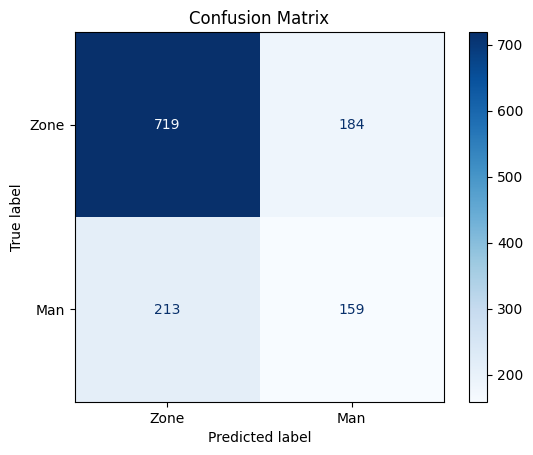

In [14]:
#################################################################
# Viz confusion matrix
#################################################################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Zone", "Man"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()